## Connect to Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Dependencies to Install

In [2]:
!pip install PyMuPDF Pillow
!pip install opencv-python
!sudo apt install tesseract-ocr
!pip install pytesseract

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.6/19.6 MB 40.7 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (4,204 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is i

In [3]:
# computer vision
import fitz
import cv2
import pytesseract
from google.colab.patches import cv2_imshow

# miscellaneous
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import random
import re

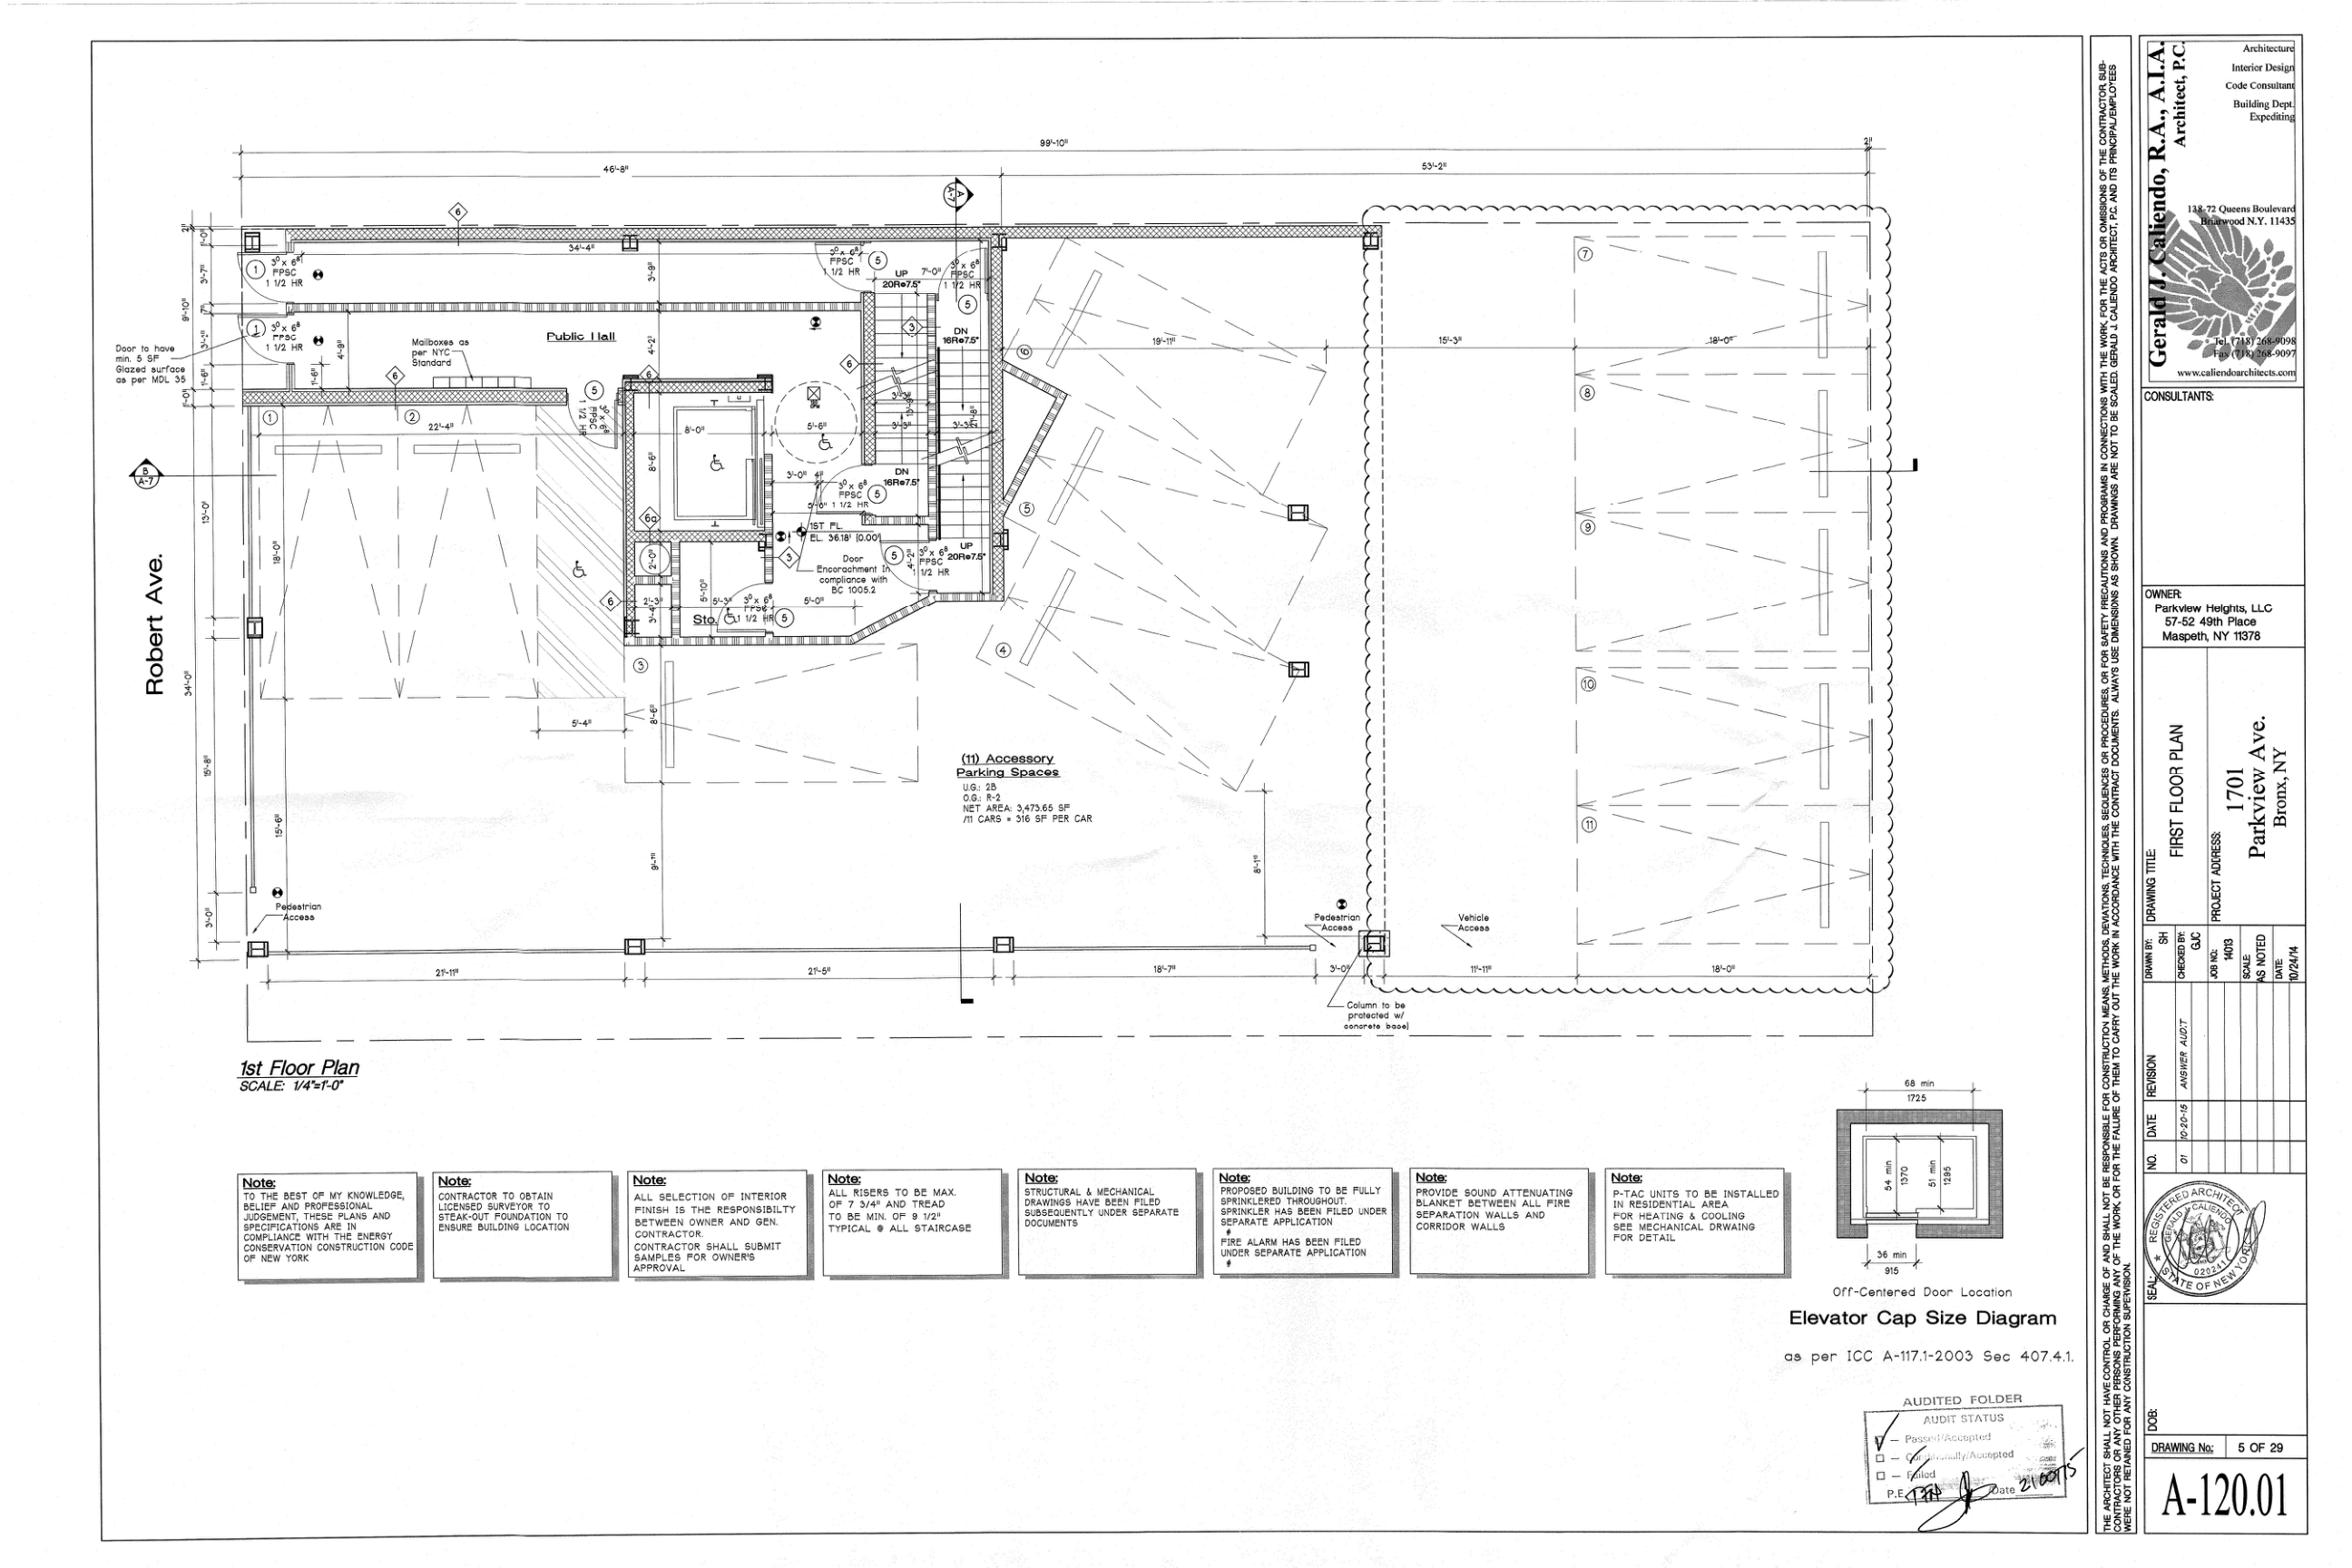

In [622]:
# Load the image using OpenCV
img = cv2.imread("/content/drive/MyDrive/*Datasets/Nearabl_Floorplan_labels/Architectural/page_5.png")

'''
arch: /content/drive/MyDrive/*Datasets/Nearabl_Floorplan_labels/Architectural/page_6.png

struct: /content/drive/MyDrive/*Datasets/Nearabl_Floorplan_labels/Structural/page_38.png

mech: /content/drive/MyDrive/*Datasets/Nearabl_Floorplan_labels/Mechanical/page_50.png

plumbing: /content/drive/MyDrive/*Datasets/Nearabl_Floorplan_labels/Plumbing/page_64.png
'''

# Display the image using cv2_imshow
cv2_imshow(img)

In [623]:
def extract_contour_by_index(preprocessed_img, index=0):
    """Extract specified contour from a preprocessed image."""
    # Check if image is already grayscale
    if len(preprocessed_img.shape) == 2:
        gray = preprocessed_img
    else:
        gray = cv2.cvtColor(preprocessed_img, cv2.COLOR_BGR2GRAY)

    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    kernel = np.ones((3, 3), np.uint8)
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    contours, _ = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)
    if index < len(sorted_contours):
        return sorted_contours[index]
    return None  # In case there are no contours

In [624]:
def preprocess_image_for_ocr(img, scale_factor=2, enhance=True):
    if len(img.shape) == 3:  # Convert to grayscale if the image has 3 channels (BGR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if enhance:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(2, 2))
        img = clahe.apply(img)
    img_resized = cv2.resize(img, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_CUBIC)
    _, img_thresh = cv2.threshold(img_resized, 150, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return img_thresh

Extracted Text: ae eS
A-120.01



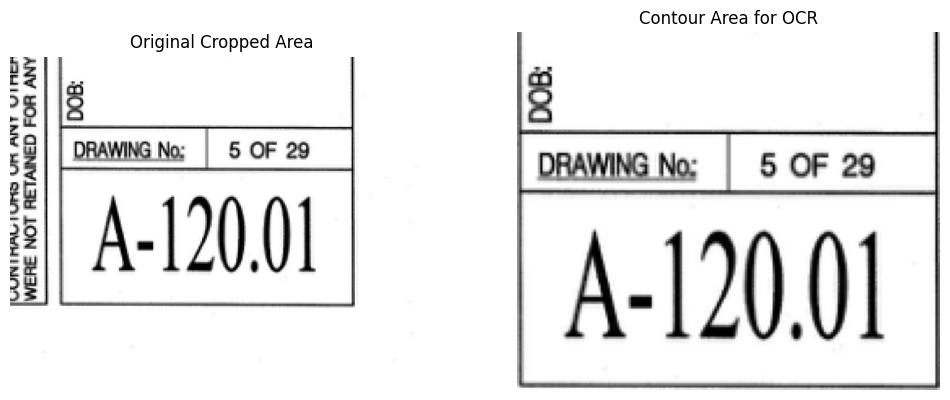

In [625]:
# Define margins or dimensions to crop from the lower right corner
crop_height = 190
crop_width = 260
y_start = img.shape[0] - crop_height
x_start = img.shape[1] - crop_width
sidebar_corner = img[y_start:, x_start:]

'''# Preprocess the image to enhance feature detection
sidebar_corner = preprocess_image_for_ocr(sidebar_corner, enhance=True)'''

# Extract the contour with an appropriate index
contour = extract_contour_by_index(sidebar_corner, index=0)  # Adjust the index as needed
if contour is not None:
    x, y, w, h = cv2.boundingRect(contour)
    contour_image = sidebar_corner[y:y+h, x:x+w]
    extracted_text = pytesseract.image_to_string(contour_image, config='--oem 3 --psm 6')
else:
    extracted_text = "No contours detected"
    contour_image = sidebar_corner

# Print the extracted text
print("Extracted Text:", extracted_text)

# Show the original cropped area and the processed contour area side by side
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(cv2.cvtColor(sidebar_corner, cv2.COLOR_BGR2RGB))
ax[0].set_title('Original Cropped Area')
ax[0].axis('off')

ax[1].imshow(contour_image, cmap='gray')
ax[1].set_title('Contour Area for OCR')
ax[1].axis('off')

plt.show()

In [626]:
def extract_blueprint_type(img):
    # Define margins or dimensions to crop to ROI where labels are located
    crop_height = 190
    crop_width = 270
    y_start = img.shape[0] - crop_height
    x_start = img.shape[1] - crop_width
    sidebar_corner = img[y_start:, x_start:]

    # Extract the contour with an appropriate index
    contour = extract_contour_by_index(sidebar_corner, index=0)
    if contour is not None:
        x, y, w, h = cv2.boundingRect(contour)
        contour_image = sidebar_corner[y:y+h, x:x+w]
        extracted_text = pytesseract.image_to_string(contour_image, config='--oem 3 --psm 6')
    else:
        extracted_text = "No contours detected"
        print(extracted_text)
        return None

    # Clean up the extracted text to remove unwanted characters
    cleaned_text = re.sub(r'[^A-Za-z0-9\-\.\s]', '', extracted_text)

    # Search for blueprint types in the cleaned extracted text, handling cases without dashes
    pattern = r'(?:[ASMP]-?)?\d{1,3}(?:\.\d+)?'  # Match optional prefixes and main part of the label
    matches = re.findall(pattern, cleaned_text)
    blueprint_types = []

    if matches:
        print("Blueprint Types Found:", matches)
        for match in matches:
            # Remove any decimal part (e.g., turn 'S-105.00' into 'S-105')
            main_label = re.sub(r'\.\d+', '', match)

            # Classify based on the main part of the label, handling cases without prefix letters
            if main_label.startswith(('S-', 'S')):
                blueprint_types.append('Structural')
            elif main_label.startswith(('A-', 'A')):
                blueprint_types.append('Architectural')
            elif main_label.startswith(('M-', 'M')):
                blueprint_types.append('Mechanical')
            elif main_label.startswith(('P-', 'P')):
                blueprint_types.append('Plumbing')

        print("Classified Blueprint Types:", blueprint_types)
        return blueprint_types
    else:
        print("No blueprint type found in text.")
        return None

blueprint_types = extract_blueprint_type(img)
print(blueprint_types)

Blueprint Types Found: ['A-120.01']
Classified Blueprint Types: ['Architectural']
['Architectural']


# Outer Wall Detection

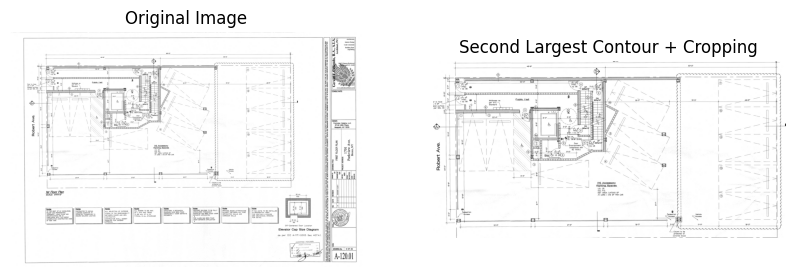

In [627]:
# Extract largest contour (index=0)
largest_contour = extract_contour_by_index(img, index=0)

# Get bounding rectangle for the largest contour
x, y, w, h = cv2.boundingRect(largest_contour)
cropped_image = img[y:y + h - 10, x:x + w - 10]

# Extract the second largest contour within the cropped image
second_largest_contour = extract_contour_by_index(cropped_image, index=0)
x2, y2, w2, h2 = cv2.boundingRect(second_largest_contour)

# Draw the second largest contour (outer boundary)
#output_image = img.copy()
# Draw the bounding rectangle for the second largest contour on the cropped image
#cv2.rectangle(cropped_image, (x2, y2), (x2 + w2, y2 + h2), (0, 255, 0), 2)
final_cropped_image = cropped_image[y2:y2+h2, x2:x2+w2]

# Plot the original image and the cropped image with the second largest contour
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

# Cropped Image with Second Largest Contour
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(final_cropped_image, cv2.COLOR_BGR2RGB))
plt.title("Second Largest Contour + Cropping")
plt.axis("off")

plt.show()

# Text Extraction via Tesseract

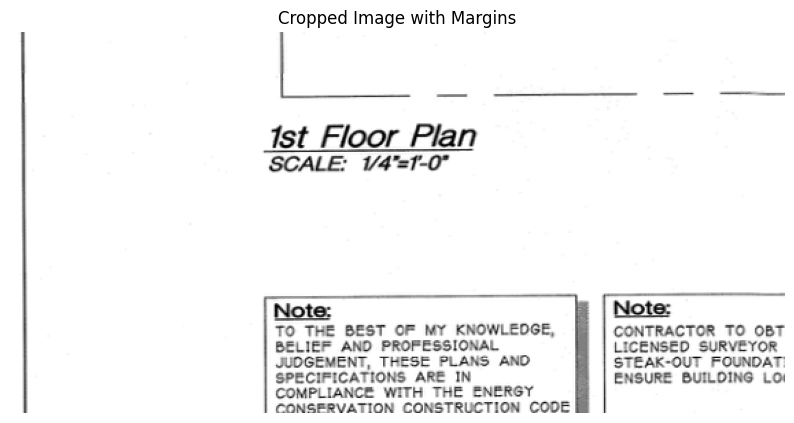

1st Floor Plan
SCALE: 1/4’=1-0"

    
   
       

        

Note:
CONTRACTOR TO OBT
LICENSED SURVEYOR
STEAK-OUT FOUNDAT
ENSURE BUILOING Lo

Note:
TO THE BEST OF MY KNOWLEDGE,
BELIEF ANO PROFESSIONAL
JUDGEMENT, THESE PLANS AND
SPECIFICATIONS ARE IN
COMPLIANCE WITH THE ENERGY

Se ecraartrna: acer tieerTenen lem

   



In [628]:
def extract_text_features(img, scale_factor=1.15):
    # Get the image dimensions
    height, width = img.shape[:2]

    # Define margins for cropping from all sides
    top_margin = 1100  # Adjust the top margin
    bottom_margin = 350  # Adjust the bottom margin
    left_margin = 100  # Adjust the left margin
    right_margin = 2000  # Adjust the right margin

    # Crop the image with the adjusted margins from all sides
    cropped_img = img[top_margin:height - bottom_margin, left_margin:width - right_margin]

    # Optionally adjust the width using the scale factor
    if scale_factor != 1:
        new_width = int(cropped_img.shape[1] * scale_factor)
        new_height = cropped_img.shape[0]  # Keep height the same
        cropped_img = cv2.resize(cropped_img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)

    # Convert to grayscale if the image is in color
    if len(cropped_img.shape) == 3:
        cropped_img = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)


    '''# Preprocess the image (optional CLAHE for contrast enhancement)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cropped_img = clahe.apply(cropped_img)'''

    # Plot the cropped image
    plt.figure(figsize=(10, 6))
    plt.imshow(cropped_img, cmap='gray')
    plt.title("Cropped Image with Margins")
    plt.axis('off')
    plt.show()

    # Extract text using OCR
    text = pytesseract.image_to_string(cropped_img)

    return text

# Assuming `img` is the image loaded via cv2.imread()
extracted_text = extract_text_features(img)
print(extracted_text)

In [620]:
def text_to_number(text):
    """Convert text floor numbers to integers."""
    floor_mapping = {
        "FIRST": 1, "SECOND": 2, "THIRD": 3, "FOURTH": 4,
        "FIFTH": 5, "SIXTH": 6, "SEVENTH": 7, "EIGHTH": 8
    }
    return floor_mapping.get(text.upper(), None)


def extract_floor_number(text):
    """
    Extracts numeric floor numbers, written floors (up to EIGHTH), 'ROOF PLAN', and 'CELLAR PLAN' from text.
    """
    # Preprocess the text for common OCR errors
    text = text.replace('Sth', '5th').replace('STH', '5TH').replace('Ast', '1st').replace('Ist', '1st')

    # Adjusted pattern to include optional characters and spaces
    pattern = r'''
        \b([1-9]|1[0-2])(?:st|nd|rd|th)?  # Numeric floors
        \s*(?:TO|--?|\s*-\s*|THRU)?\s*
        ([1-9]|1[0-2])?(?:st|nd|rd|th)?
        \s*[Ff][Ll][Oo][Oo][Rr]\s*[Pp][Ll][Aa][Nn]
        |
        \b(FIRST|SECOND|THIRD|FOURTH|FIFTH|SIXTH|SEVENTH|EIGHTH)
        (?:\s*(?:TO|--?|\s*-\s*|THRU)\s*(FIRST|SECOND|THIRD|FOURTH|FIFTH|SIXTH|SEVENTH|EIGHTH))?
        \s*[Ff][Ll][Oo][Oo][Rr]\s*[Pp][Ll][Aa][Nn]
        |
        \b(ROOF)\s*[Pp][Ll][Aa][Nn]
        |
        \b(CELL[AE]R)\s*[Ff]?[Ll]?[Oo]?[Oo]?[Rr]?[\s\-\.]*[Pp][Ll][Aa][Nn]
        |
        \b(FOUNDATION)\s*[Pp][Ll][Aa][Nn]
    '''

    matches = re.finditer(pattern, text, re.IGNORECASE | re.VERBOSE | re.DOTALL)
    floor_set = set()

    for match in matches:
        if match.groups()[0]:
            # Numeric floor range
            start_floor, end_floor = match.groups()[0], match.groups()[1]
            if end_floor is None:
                end_floor = start_floor
            floor_set.update(str(i) for i in range(int(start_floor), int(end_floor) + 1))
        elif match.groups()[2]:
            # Written floor range
            start_floor, end_floor = text_to_number(match.groups()[2]), text_to_number(match.groups()[3])
            if end_floor is None:
                end_floor = start_floor
            floor_set.update(str(i) for i in range(start_floor, end_floor + 1))
        elif match.groups()[4]:
            # Roof plan
            floor_set.add('roof')
        elif match.groups()[5]:
            # Cellar plan
            floor_set.add('cellar')
        elif match.groups()[6]:
            # Foundation plan
            floor_set.add('foundation')

    if floor_set:
        return ', '.join(sorted(floor_set, key=lambda x: (not x.isnumeric(), x)))
    else:
        print("No floors found")
        return "N/A"


def extract_scales(text):
    # Adjusted pattern to match scales like 1/4"=1'-0", 1/4’=1'-0", and similar variations
    pattern = r'[Ss][Cc][Aa][Ll][Ee]\s*[:=]?\s*([\d\/]+[\'"°“”’]?\s*[=]?\s*\d+[\'"°“”’]?\s*-\s*\d+[\'"°“”’]?)'

    # Search for the pattern in the text
    match = re.search(pattern, text)

    if match:
        scale = match.group(1)

        # Clean up common OCR misreads and formatting
        corrections = {
            "V": "1", "l": "1", "I": "1", "7": "1", "f": "1", "°": "\"", "“": "\"", "”": "\"", "'": "\"", "’": "\"",
            "–": "-", "’": "'", "=": " = "
        }

        # Replace misread characters
        for wrong, correct in corrections.items():
            scale = scale.replace(wrong, correct)

        # Ensure that 1/4 remains as 1/4 and does not get turned into 11/4
        scale = scale.replace("11/4", "1/4")

        # Remove any extra spaces around digits and units (e.g., 1 - 0" should be 1-0")
        scale = re.sub(r'\s*-\s*', '-', scale)  # Remove spaces around "-"
        scale = re.sub(r'\s*\/\s*', '/', scale)  # Remove spaces around "/"
        scale = re.sub(r'\s*\"\s*', '"', scale)  # Remove spaces around "
        scale = re.sub(r'\s*\=\s*', ' = ', scale)  # Ensure equal sign has spaces around it

        # Ensure that the scale ends correctly (e.g., add missing inches after dash if necessary)
        if scale.endswith("-"):
            scale = scale.rstrip("-") + "0\""

        # Normalize the format further if necessary (ensure format X" = Y"-Z")
        if "=" not in scale:
            parts = scale.split("-")
            if len(parts) == 2:
                scale = parts[0].strip() + "\" = " + parts[1].strip() + "\""

        return scale  # Return the corrected and formatted scale

    return "N/A"


def extract_floor_elevation(text):
    """
    Extracts floor elevations from the text and associates them with their respective floor numbers.
    Corrects common OCR misreads like 'STH' -> '5TH' and handles variations in floor and elevation formats.
    Returns a formatted string with elevations corresponding to floor numbers.
    """
    # Preprocess the text to correct common OCR misreads like 'STH' -> '5TH'
    text = text.replace('STH', '5TH').replace('sth', '5th')

    # Adjusted pattern to match both numeric and written floor numbers, and their elevations
    pattern = r'(\d+)(?:ST|ND|RD|TH)?\s*[Ff][Ll][Rr]\.?\s*[Ee][Ll]\.?\s*([\d,]+(?:\.\d+)?)\s*[\'"“”°]?'

    # Try variations with optional spacing or punctuation around "FLR. EL."
    alternative_pattern = r'(\d+)(?:ST|ND|RD|TH)?\s*[Ff][Ll][Rr]\s*\.?\s*[Ee][Ll]\s*\.?\s*([\d,]+(?:\.\d+)?)\s*[\'"“”°]?'

    # First, try matching with the primary pattern
    matches = re.findall(pattern, text)

    if not matches:
        # If no matches, try with the alternative pattern
        matches = re.findall(alternative_pattern, text)

    elevations = []

    for match in matches:
        floor_number = match[0]  # Extract floor number (e.g., 2, 3, 4, etc.)
        elevation = match[1].replace(',', '.').strip()  # Normalize the decimal and remove extra commas

        # Ensure the elevation ends with a single-quote for feet
        if not elevation.endswith("'"):
            elevation += "'"

        # Store floor number and its corresponding elevation
        elevations.append(f"{floor_number}: {elevation}")

    # Format the list of elevations into a string
    if elevations:
        formatted_elevations = ', '.join(elevations)
        return formatted_elevations
    else:
        return "N/A"

In [621]:
floor_number = extract_floor_number(extracted_text)
scale = extract_scales(extracted_text)
elevation = extract_floor_elevation(extracted_text)

print("Extracted Floor Number:", floor_number)
print("Extracted Scale:", scale)
print("Extracted Floor Elevation:", elevation)

Extracted Floor Number: 1
Extracted Scale: 1/4' = 1-0"
Extracted Floor Elevation: N/A


# Corners Boundary Detection

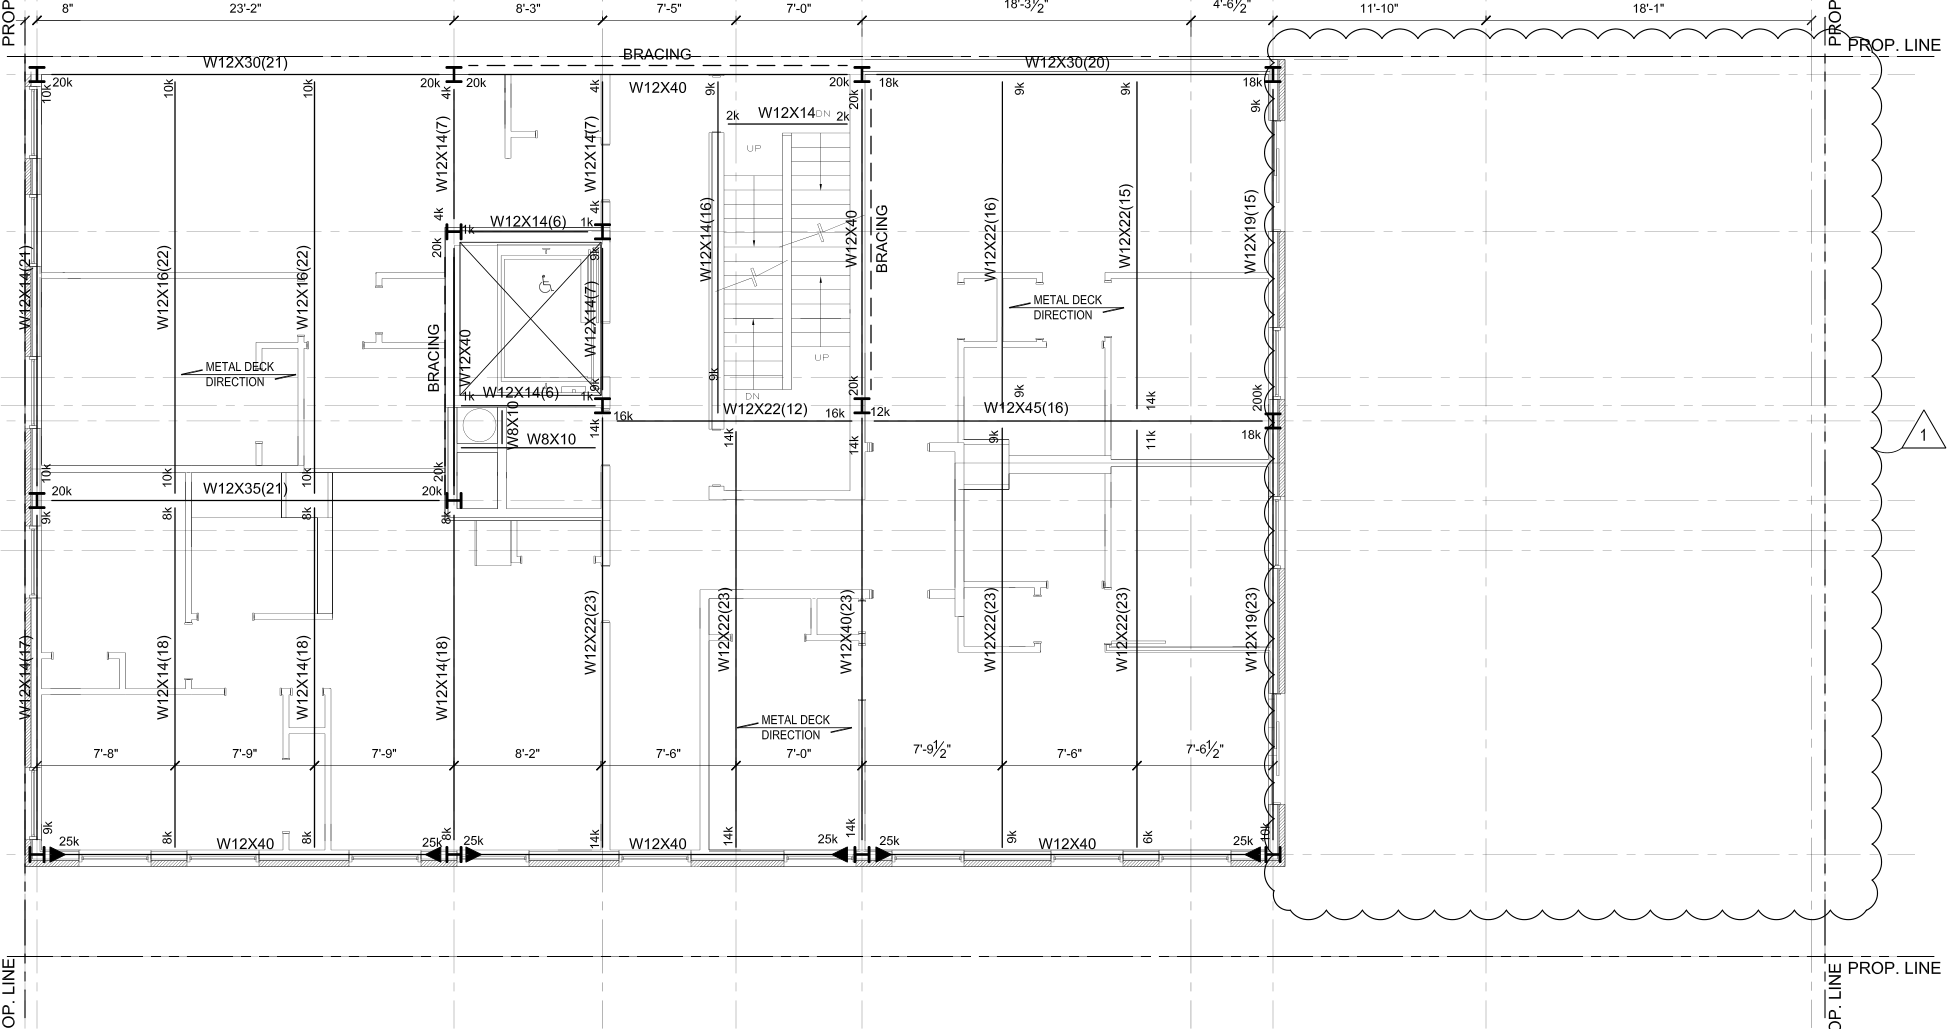


Corners of the rectangle: [(225, 275), (2172, 275), (225, 1304), (2172, 1304)]
Width: 1947
Height: 1029
Perimeter: 5952
Area: 2003463
Aspect Ratio: 1.89
Centroid: (1198.5, 789.5)
Diagonal Length: 2202.19


In [420]:
corners = [(x2, y2), (x2 + w2, y2), (x2, y2 + h2), (x2 + w2, y2 + h2)]
width = w2
height = h2

perimeter = 2 * (width + height)
area = width * height
aspect_ratio = width / height
centroid = (x2 + width / 2, y2 + height / 2)
diagonal_length = (width ** 2 + height ** 2) ** 0.5


cv2_imshow(final_cropped_image)
print("\nCorners of the rectangle:", corners)
print(f"Width: {width}")
print(f"Height: {height}")
print(f"Perimeter: {perimeter}")
print(f"Area: {area}")
print(f"Aspect Ratio: {aspect_ratio:.2f}")
print(f"Centroid: {centroid}")
print(f"Diagonal Length: {diagonal_length:.2f}")